In [5]:
import pandas as pd
import pandas as pd
import numpy as np
from numpy import exp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score,KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import PolynomialFeatures,StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from scipy.stats import randint as sp_randint
import random

In [6]:
concrete_df = pd.read_csv('concrete.csv')
concrete_df.shape #of rows before dropping duplicates, Nulls, or etc.

(1030, 9)

In [7]:
# #Meaning of Each attributes
# 1) Cement - Cement Content in Mixture
# 2) Blast Furnace Slag - Slag Content in Mixture
# 3) Fly Ash - Ash Content in Mixture
# 4) Water - Water Content in Mixture
# 5) Superplasticizer - Plasticizer Content in Mixture
# 6) Coarse Aggregate - Coarse Aggregate Content in Mixture
# 7) Fine Aggregate - Fine (less rough than Coarse) Aggregate Content in Mixture
# 8) Age - Age of Mixture
# 9) Concrete compressive strength - Total compressive strength of the Total Mixture

# 1. Univariate Analysis

In [8]:
#Sanity Check of Data Types
def Sanity_Check(data):
        dtype = data.dtypes
        null = data.isnull().sum()
        unique = data.nunique()
        
        data_conc = pd.concat([dtype,null,unique], axis=1)
        data_conc.columns = ['dtype','null','unique']
        data_conc['%Null'] = data_conc['null'].values/len(data)
        
        return data_conc
Sanity_Check(concrete_df)

# No Null Values observed

,dtype,null,unique,%Null
cement,float64,0,278,0.0
slag,float64,0,185,0.0
ash,float64,0,156,0.0
water,float64,0,195,0.0
superplastic,float64,0,111,0.0
coarseagg,float64,0,284,0.0
fineagg,float64,0,302,0.0
age,int64,0,14,0.0
strength,float64,0,845,0.0


In [9]:
#Check Skewness and other statistical details on Continuous Variable
#- Description
concrete_df_stat = pd.concat([concrete_df.describe().T,concrete_df.skew()],axis=1).rename(columns = {0:'Skewness'})
concrete_df_stat['Range']=concrete_df_stat['max']-concrete_df_stat['min']
concrete_df_stat
#age is the most skewed variable

,count,mean,std,min,25%,50%,75%,max,Skewness,Range
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0,0.509481,438.00
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4,0.800717,359.40
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1,0.537354,200.10
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0,0.074628,125.20
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2,0.907203,32.20
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0,-0.040220,344.00
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6,-0.253010,398.60
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0,3.269177,364.00
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6,0.416977,80.27


Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')


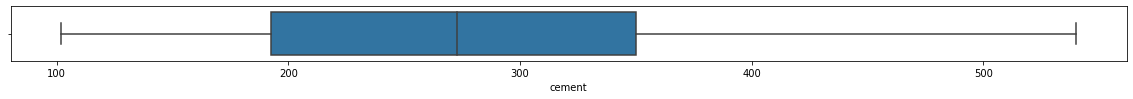

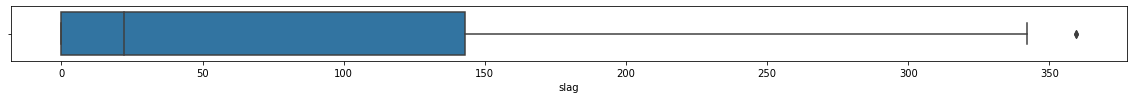

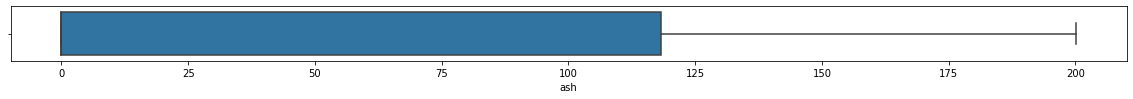

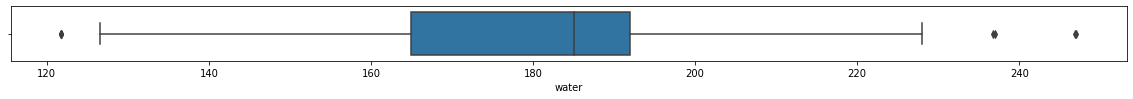

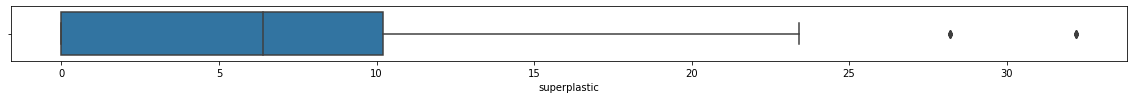

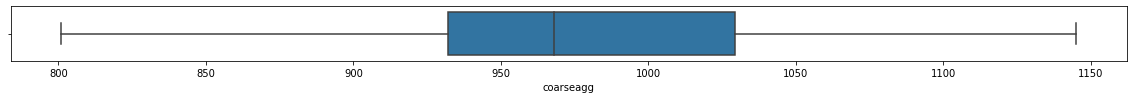

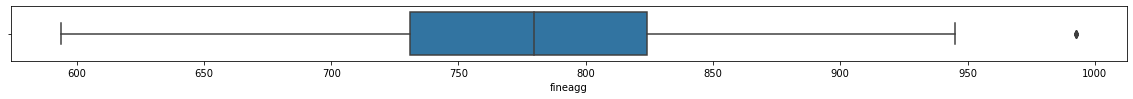

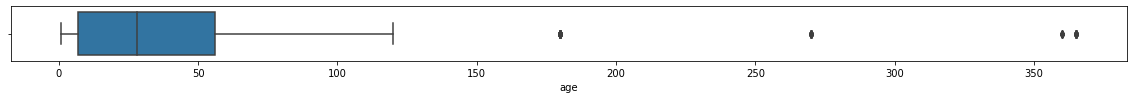

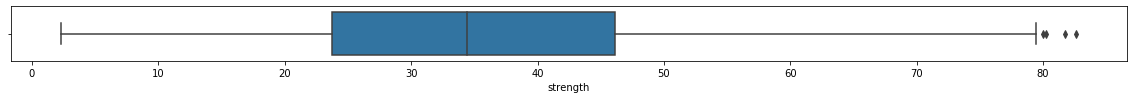

In [10]:
#Check if there is any weird value in any Continuous feature [Outlier detection and normal Plot] 2
print(concrete_df.columns)
for c in concrete_df.columns:
    fig, axs = plt.subplots(figsize= (20,1))
    cont_plot = sns.boxplot(x=concrete_df[c])
    plt.show()
#Not much of Outliers within Features. Keeping the outliers for info

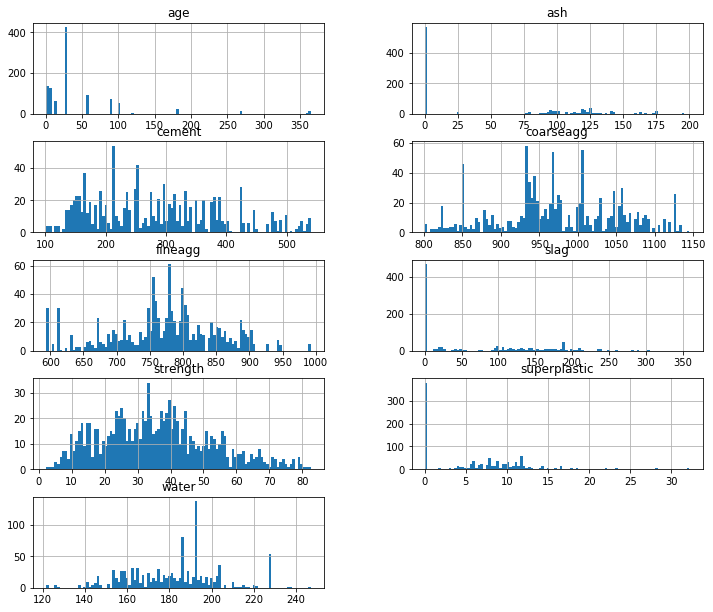

In [11]:
#look at Histogram excluding first column that is just indication of number of rows
columns = list(concrete_df)[:]
concrete_df[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));
#Ash, Slag, and Superplastic is full of 0's. 
#Try correlating by binning and pull bivariate charts using continuous vs categorical

In [12]:
concrete_dup_rows = concrete_df.loc[concrete_df.duplicated()==True]
concrete_dup_rows.sort_values(by='strength').drop_duplicates()
#Below are the rows that have duplicates hence will need to drop all of these duplicates

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
468,252.0,0.0,0.0,185.0,0.0,1111.0,784.0,28,19.69
278,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
400,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
884,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
933,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
577,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29
517,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56,64.30
482,425.0,106.3,0.0,153.5,16.5,852.1,887.1,91,65.20
525,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28,71.30
604,362.6,189.0,0.0,164.9,11.6,944.7,755.8,56,77.30


In [13]:
concrete_df.drop_duplicates().shape #Number of rows after dropping duplicates

(1005, 9)

# 2. Bivariate

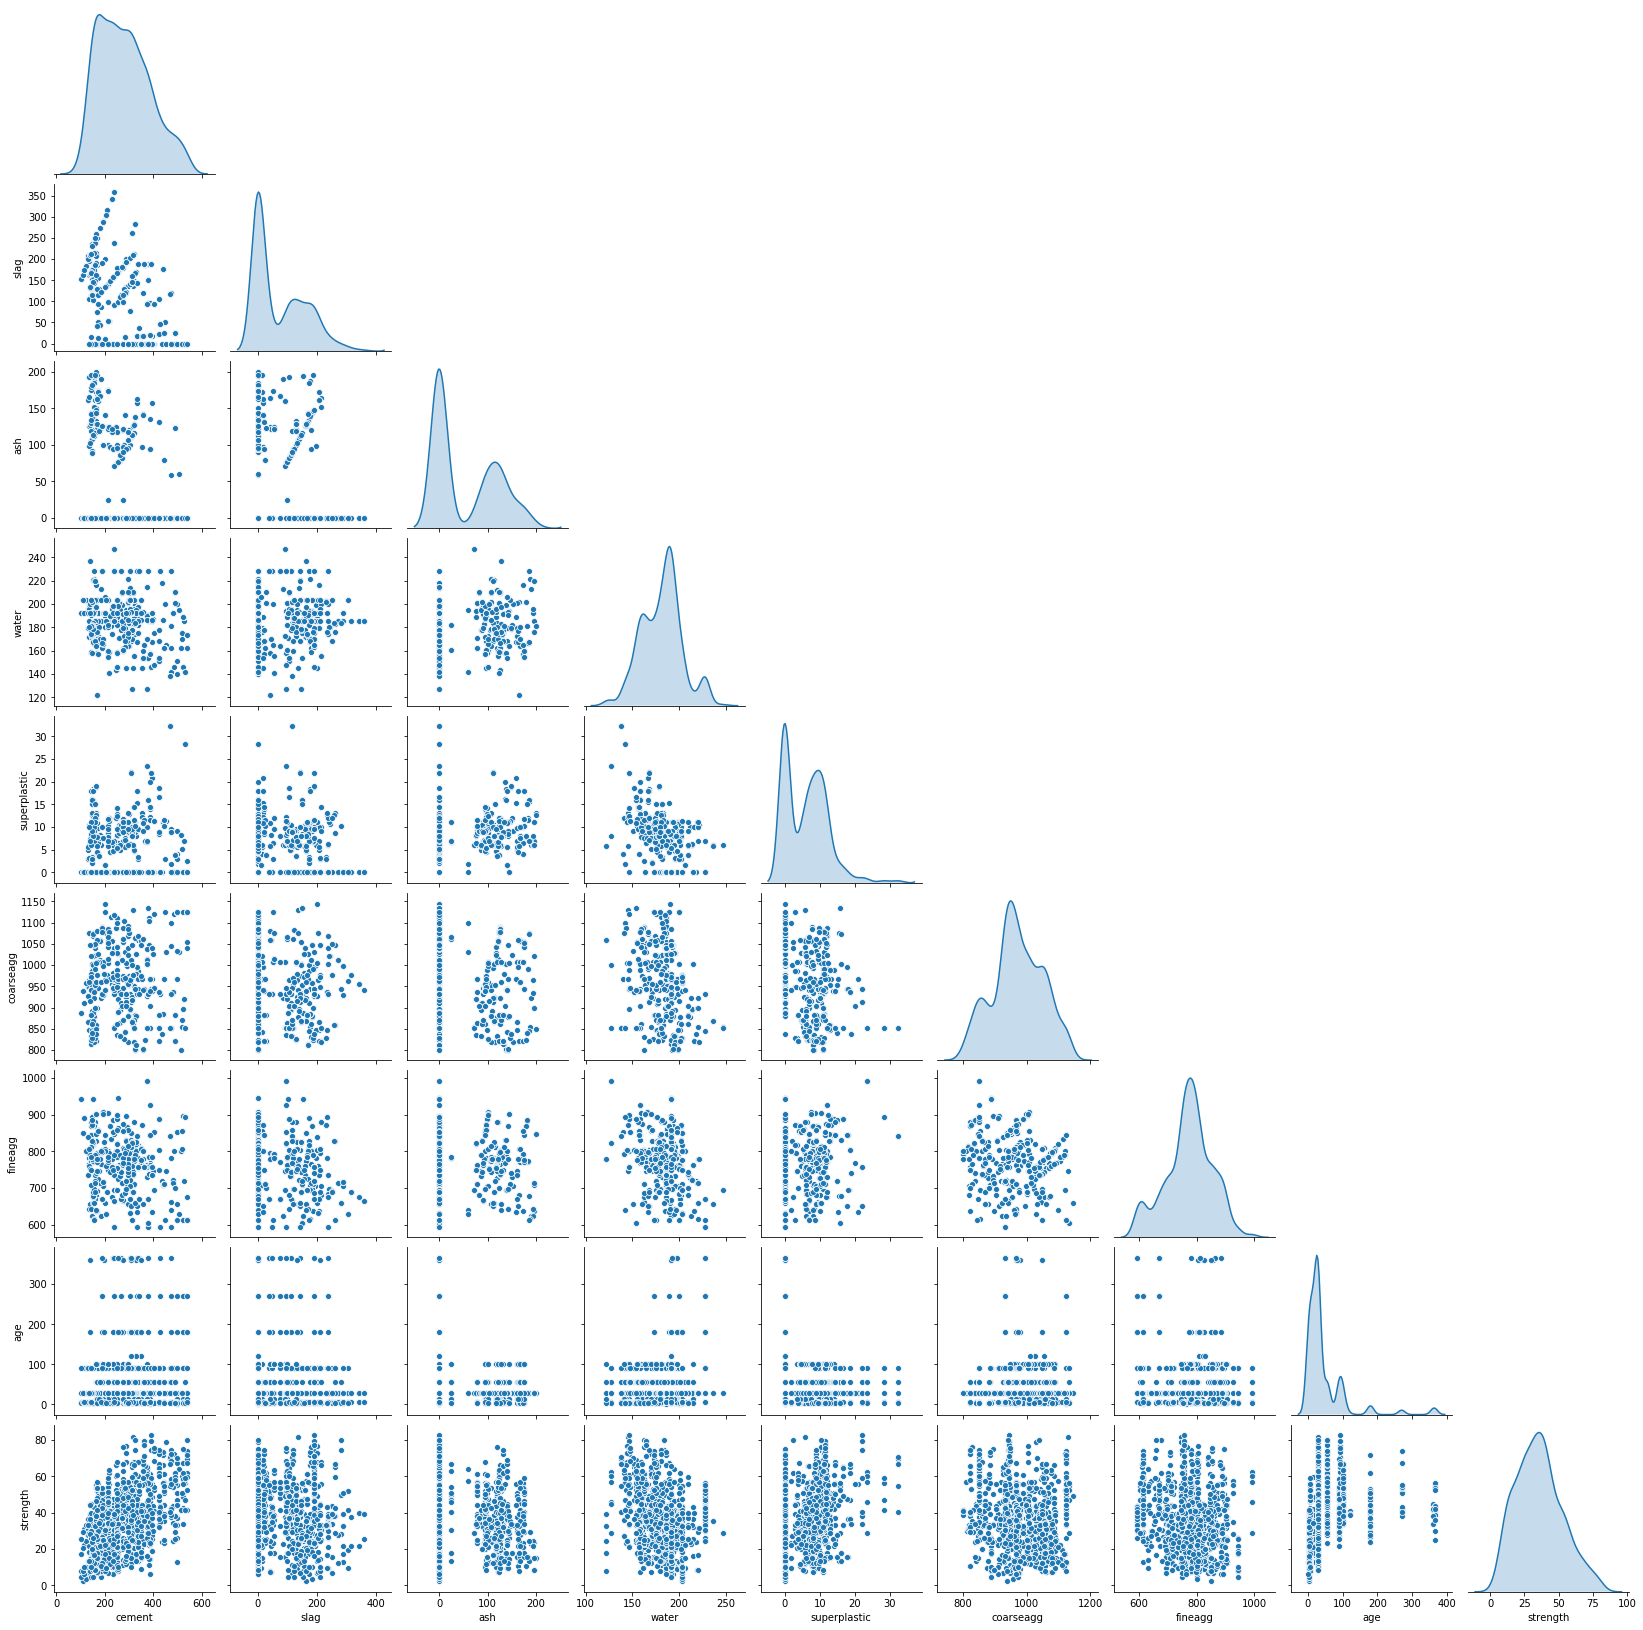

In [14]:
sns.pairplot(concrete_df,diag_kind='kde', corner=True)
#Strength is well distributed hence no need to upsample or downsample

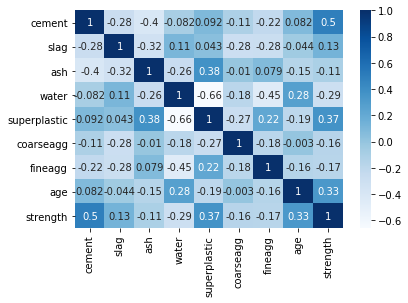

In [15]:
#Superplastic vs Wafer is correlated to 0.66 but not high enough to drop the features.
#No features will be dropped for modeling.
corr = concrete_df.corr() 
sns.heatmap(corr, annot=True, cmap='Blues')

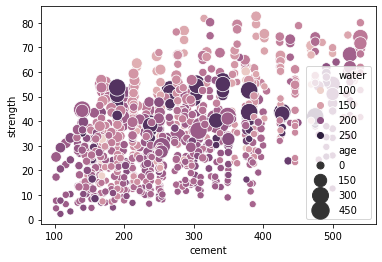

In [16]:
sns.scatterplot(y="strength", x="cement", hue="water",size="age", data=concrete_df,  sizes=(50, 300))
#older the Cement, more water
#Strength increase as cement increase
# harder the strength when less water is used

In [17]:
#Bivariate using Binning features with full of 0's
#Ash, Slag, and Superplastic is full of 0's. 
concrete_df_bin = concrete_df.copy()
ash_list_bin = [0]
ash_bin_label = []
for i in range(1,22):
    ash_list_bin.append(i*10)
    ash_bin_label.append(str((i-1)*10)+'-'+str(i*10+0.99))    
print(ash_list_bin)
print(ash_bin_label)
concrete_df_bin['ash_bin'] = pd.cut(concrete_df_bin['ash'], bins=ash_list_bin , labels=ash_bin_label).fillna('0-10.99')

slag_list_bin = [0]
slag_bin_label = []
for j in range(1,38):
    slag_list_bin.append(j*10)
    slag_bin_label.append(str((j-1)*10)+'-'+str(j*10+0.99))    
print(slag_list_bin)
print(slag_bin_label)
concrete_df_bin['slag_bin'] = pd.cut(concrete_df_bin['slag'], bins=slag_list_bin , labels=slag_bin_label).fillna('0-10.99')


superp_list_bin = [0]
superp_bin_label = ['0-2']
for j in range(1,18):
    superp_list_bin.append(j*2)
for k in range(2,18):    
    superp_bin_label.append(str((k-1)*2+0.01)+'-'+str(k*2))    
print(superp_list_bin)
print(superp_bin_label)
concrete_df_bin['superp_bin'] = pd.cut(concrete_df_bin['superplastic'], bins=superp_list_bin , labels=superp_bin_label).fillna('0-2')





[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]
['0-10.99', '10-20.99', '20-30.99', '30-40.99', '40-50.99', '50-60.99', '60-70.99', '70-80.99', '80-90.99', '90-100.99', '100-110.99', '110-120.99', '120-130.99', '130-140.99', '140-150.99', '150-160.99', '160-170.99', '170-180.99', '180-190.99', '190-200.99', '200-210.99']
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370]
['0-10.99', '10-20.99', '20-30.99', '30-40.99', '40-50.99', '50-60.99', '60-70.99', '70-80.99', '80-90.99', '90-100.99', '100-110.99', '110-120.99', '120-130.99', '130-140.99', '140-150.99', '150-160.99', '160-170.99', '170-180.99', '180-190.99', '190-200.99', '200-210.99', '210-220.99', '220-230.99', '230-240.99', '240-250.99', '250-260.99', '260-270.99', '270-280.99', '280-290.99', '290-300.99', '300-310.99', '310-320.99', '320-330.99', '3

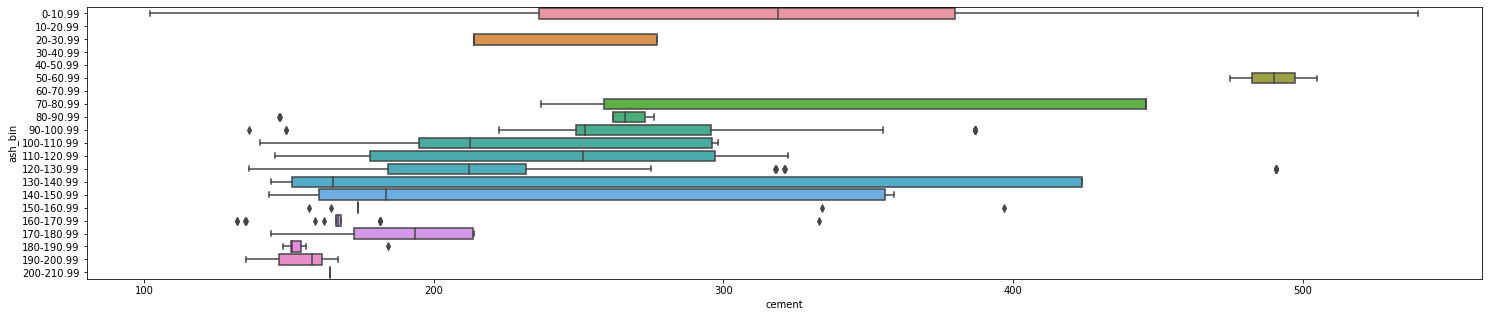

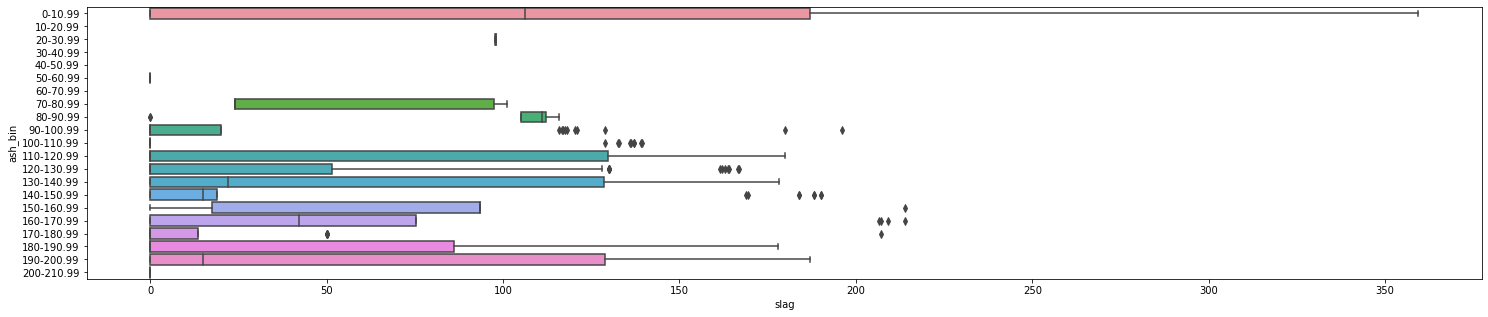

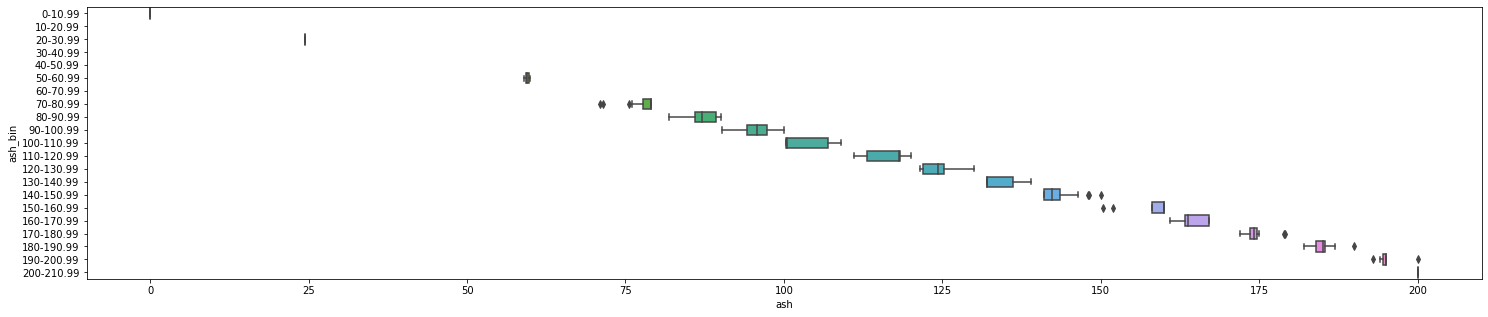

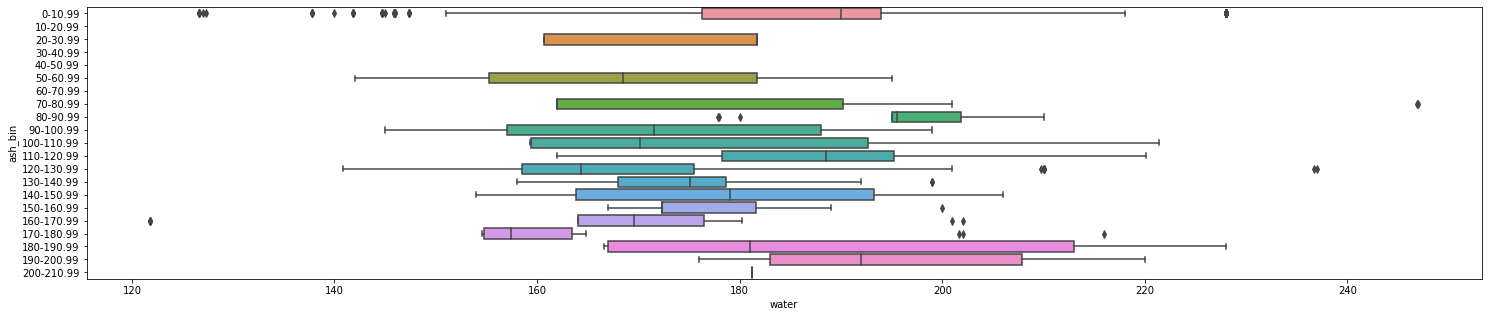

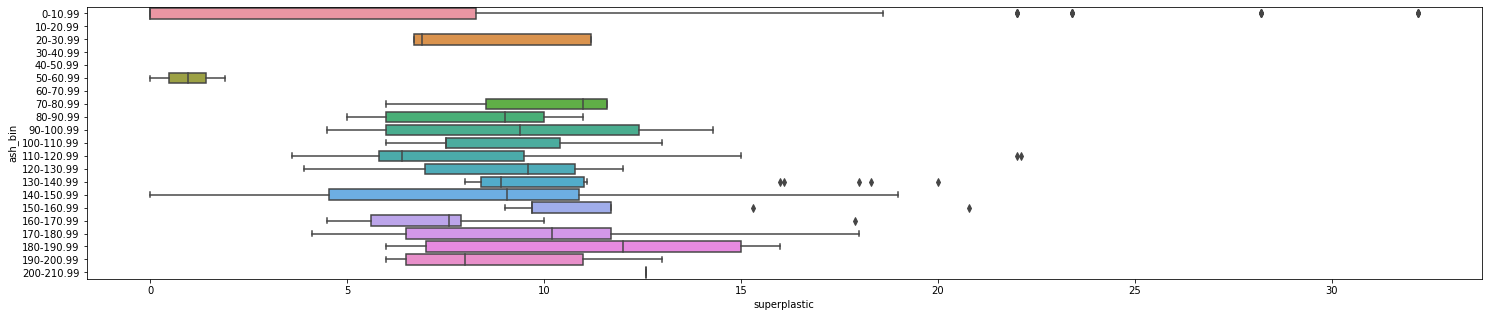

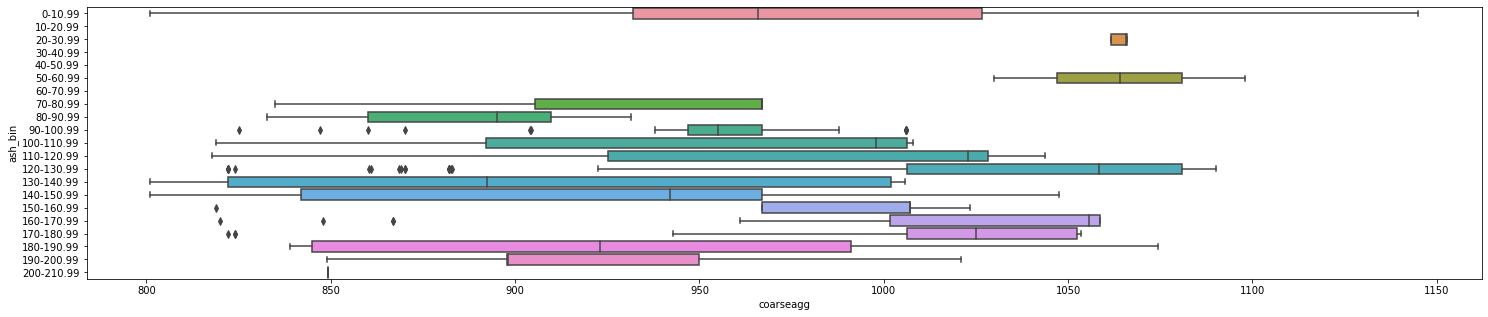

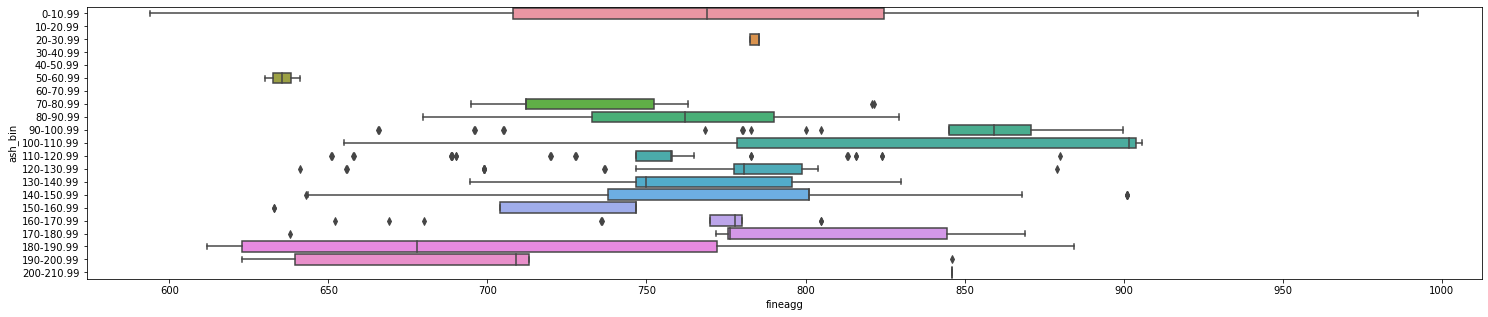

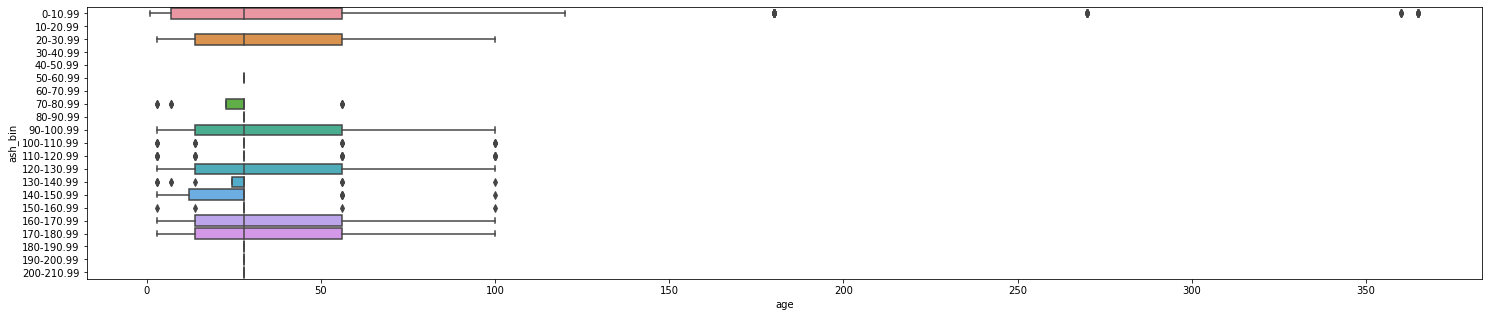

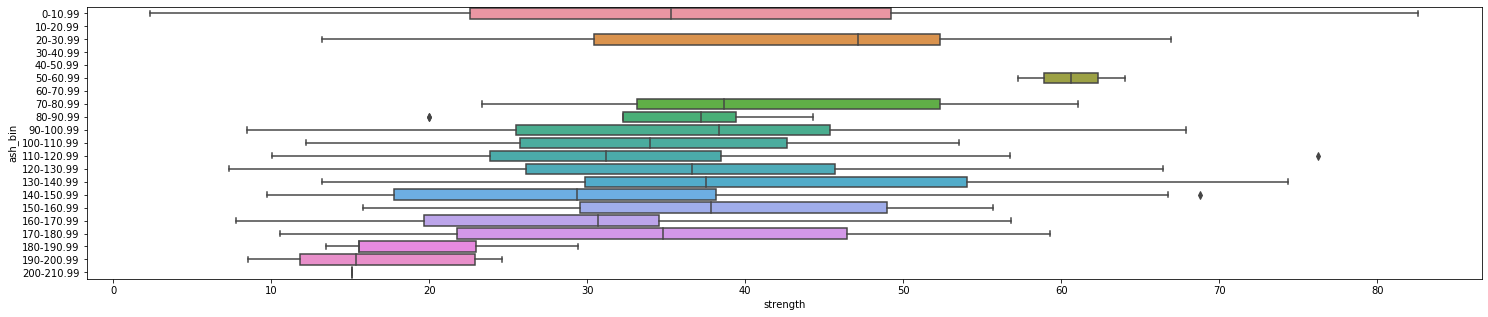

In [18]:
#bi-plot for ash_bin
for l in concrete_df_bin.columns[:-3]:
    fig, axs = plt.subplots(figsize= (25,5))
    cont_bi_box_plot_ash = sns.boxplot(x=concrete_df_bin[l],y=concrete_df_bin['ash_bin'])
    plt.show()
#No correlation is visible

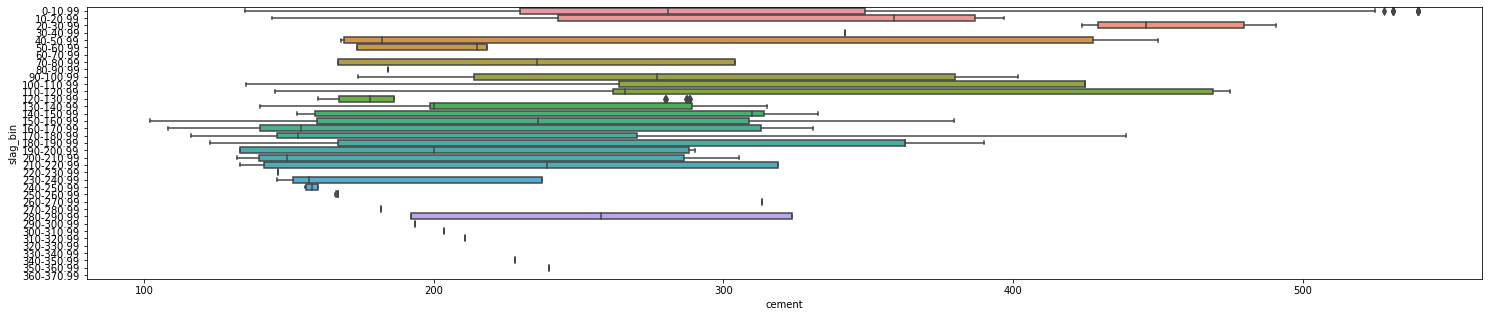

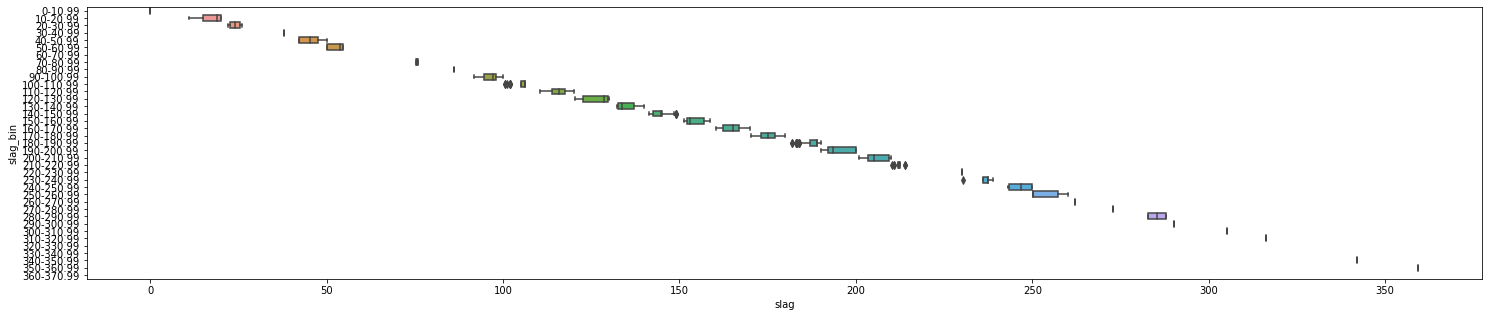

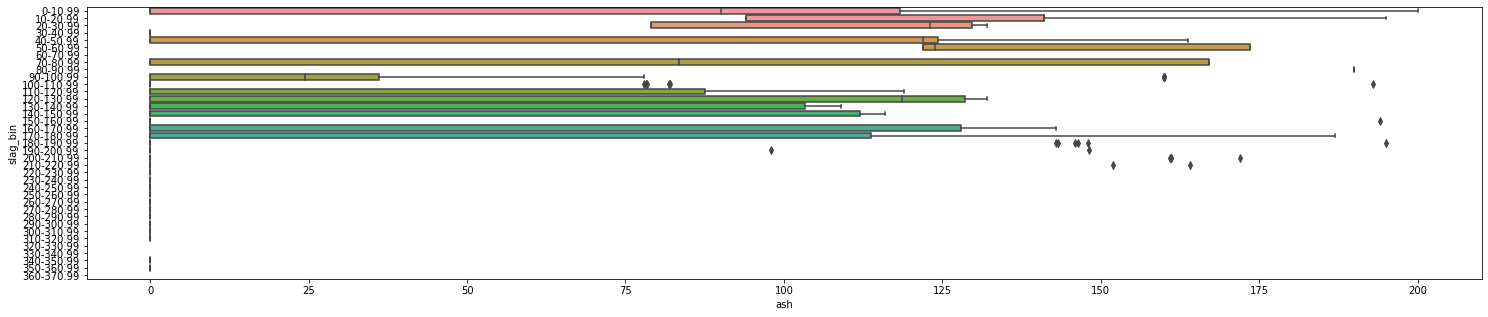

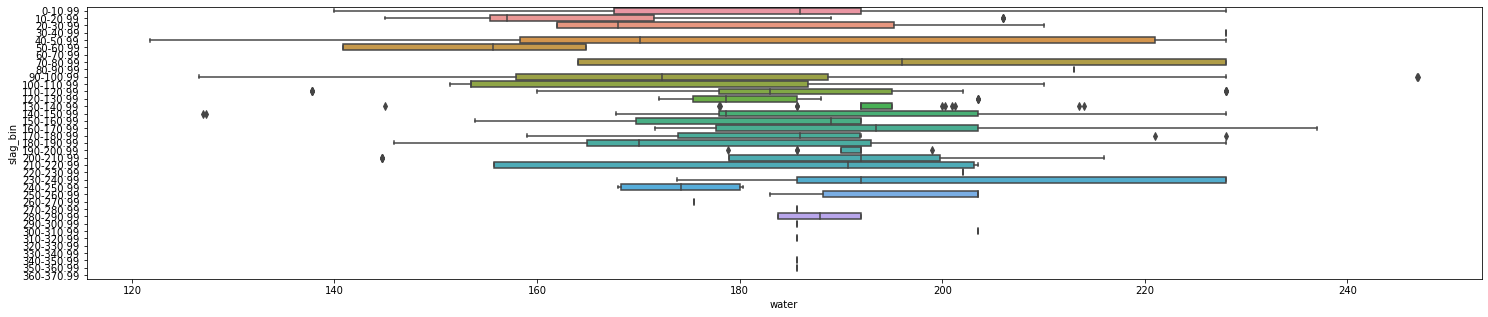

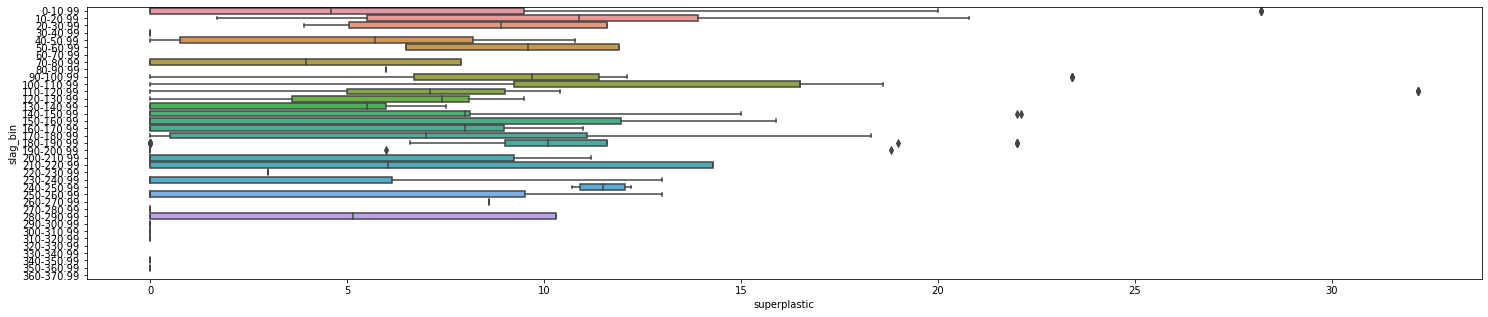

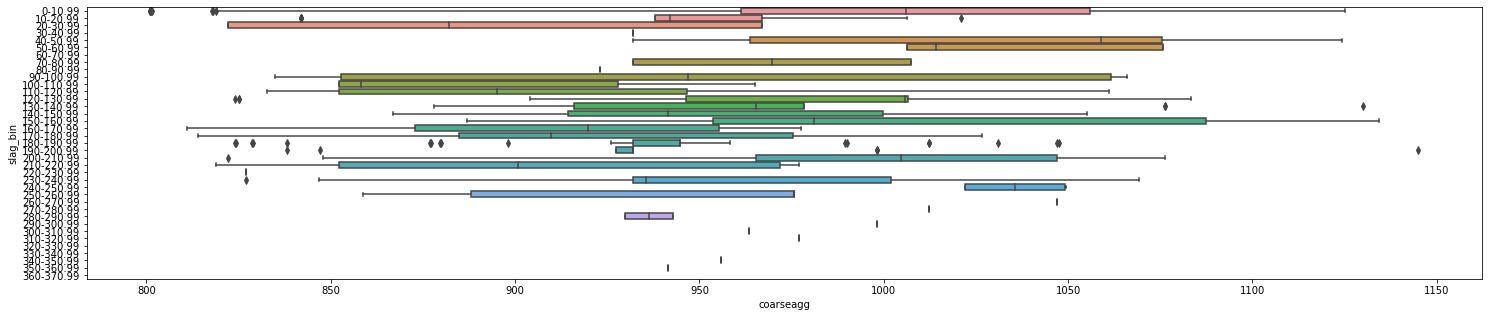

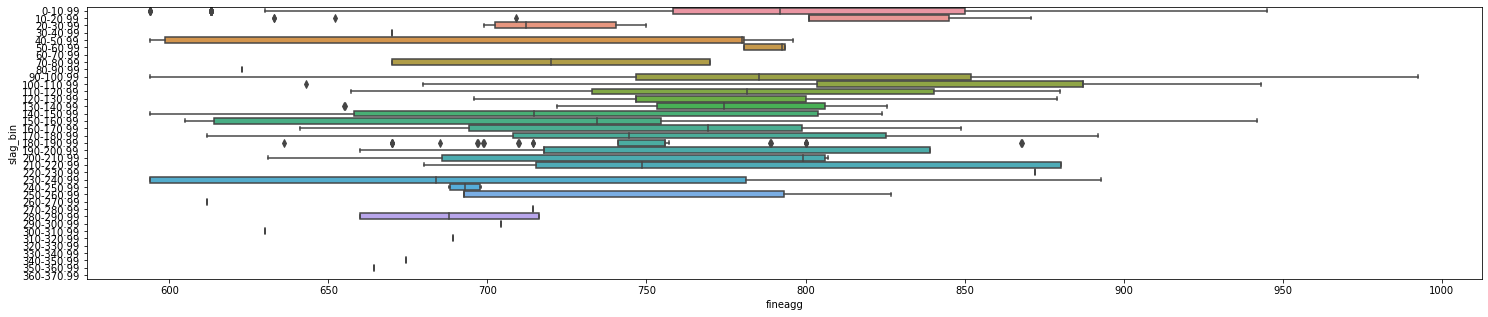

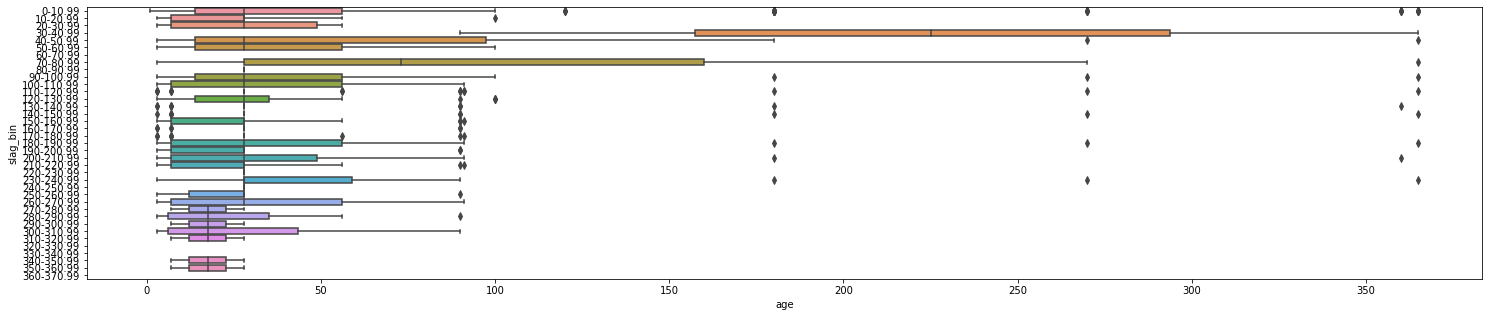

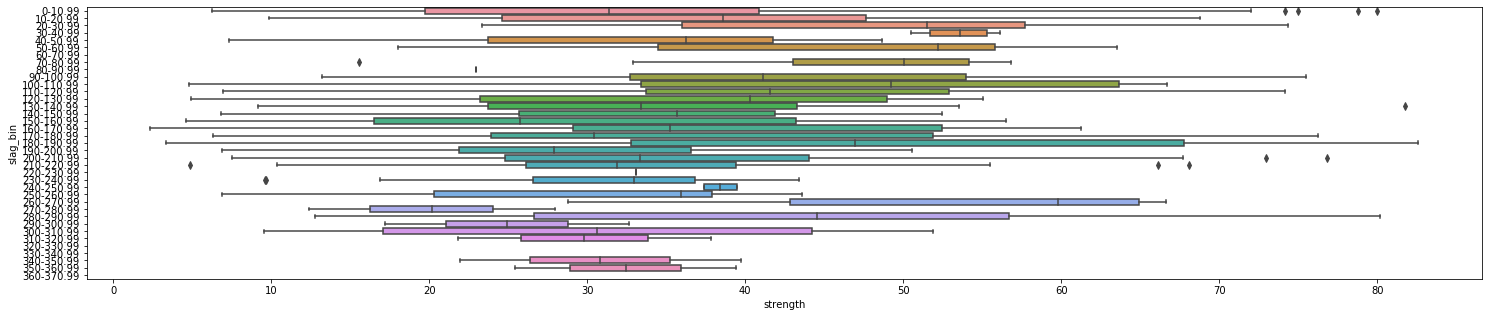

In [19]:
#bi-plot for slag_bin
for m in concrete_df_bin.columns[:-3]:
    fig, axs = plt.subplots(figsize= (25,5))
    cont_bi_box_plot_slag = sns.boxplot(x=concrete_df_bin[m],y=concrete_df_bin['slag_bin'])
    plt.show()
#No correlation is visible

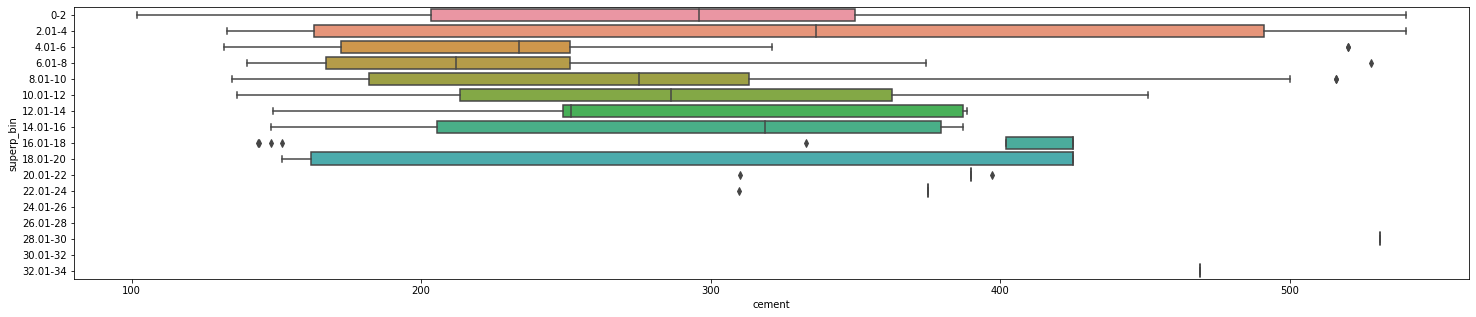

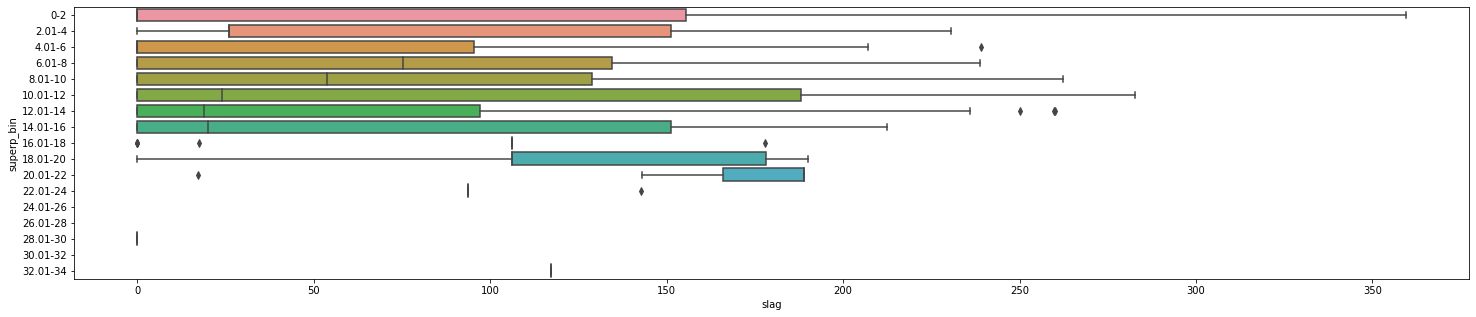

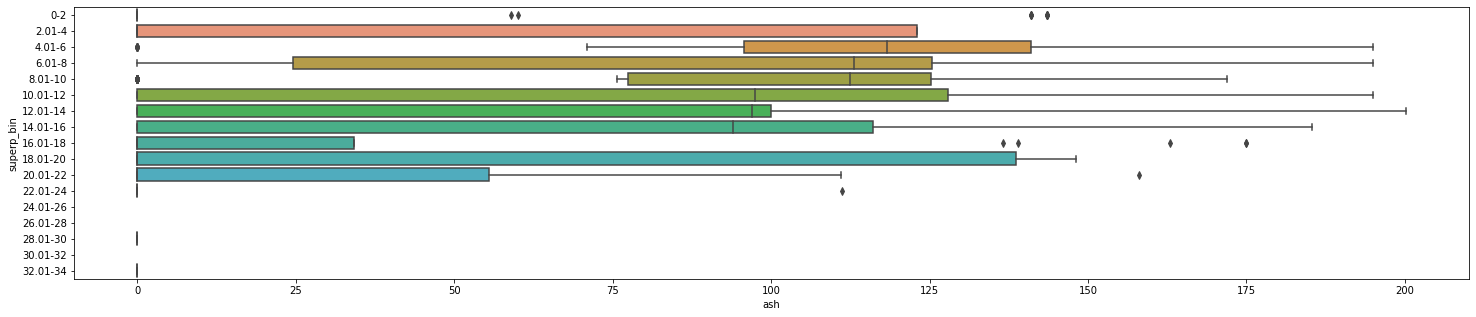

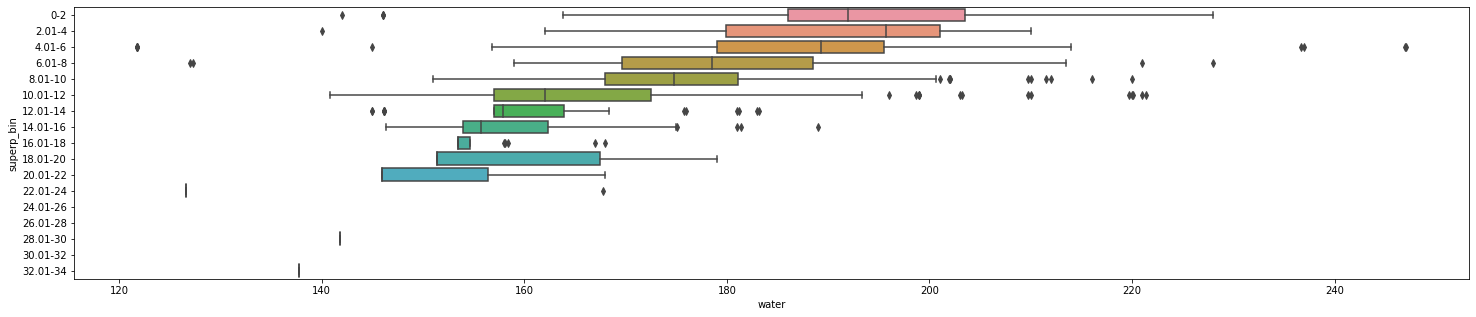

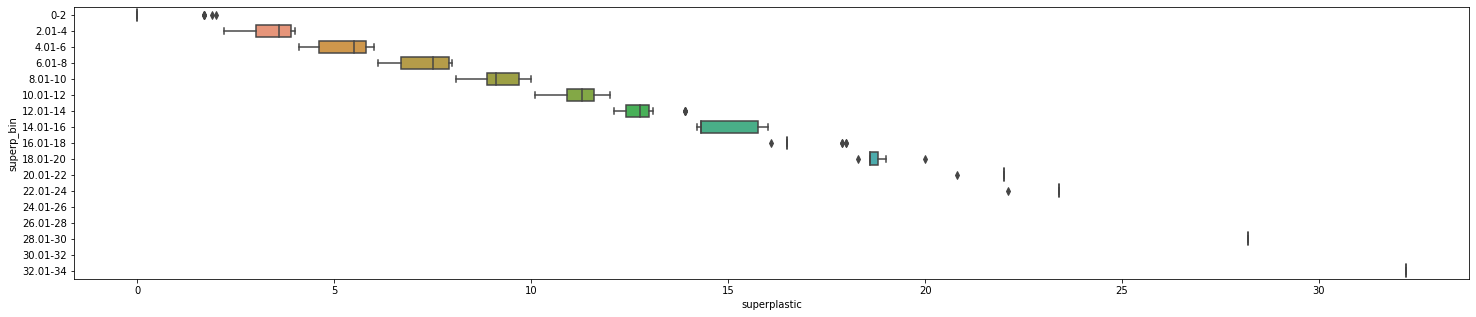

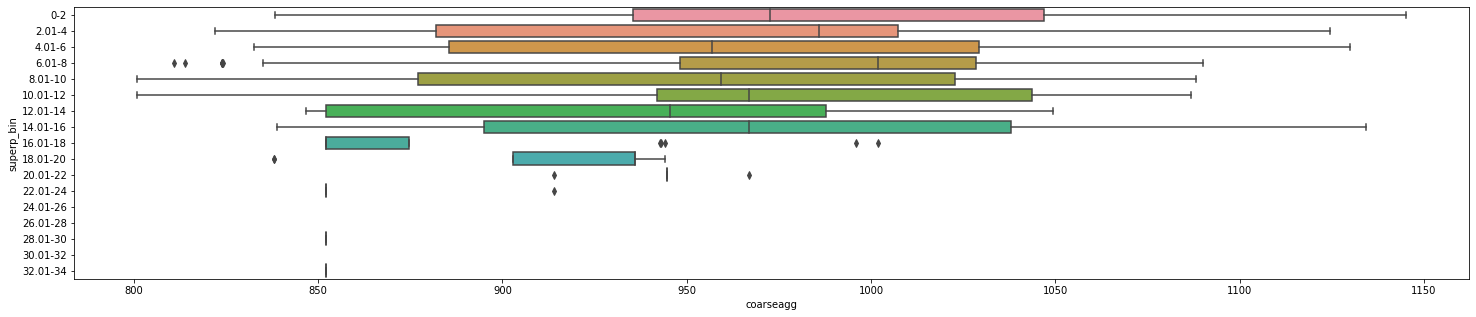

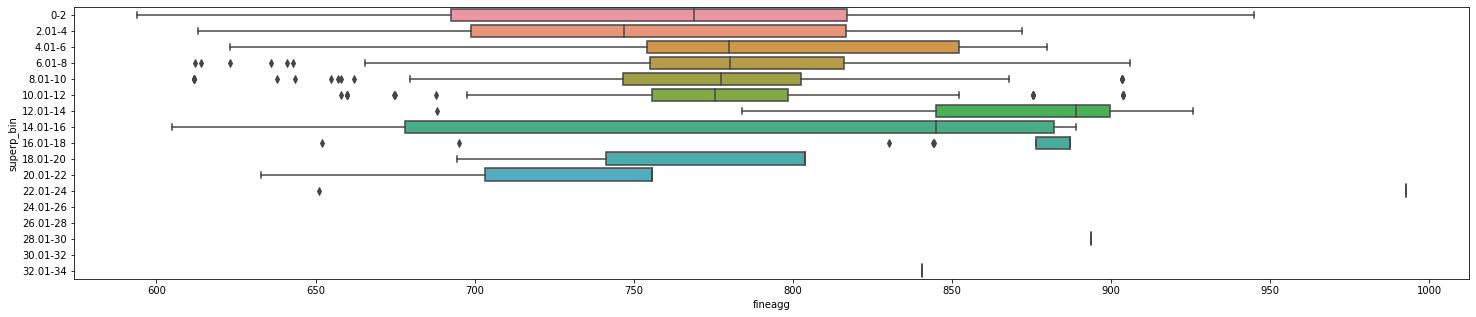

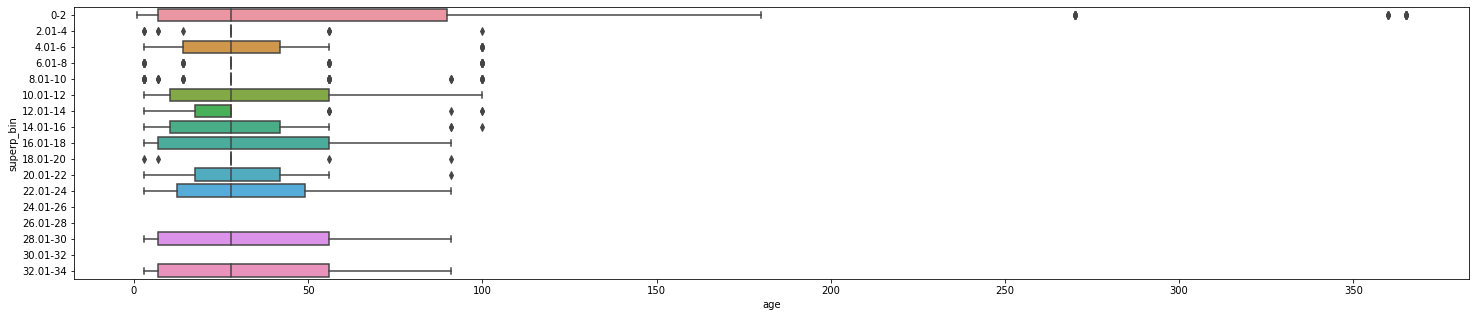

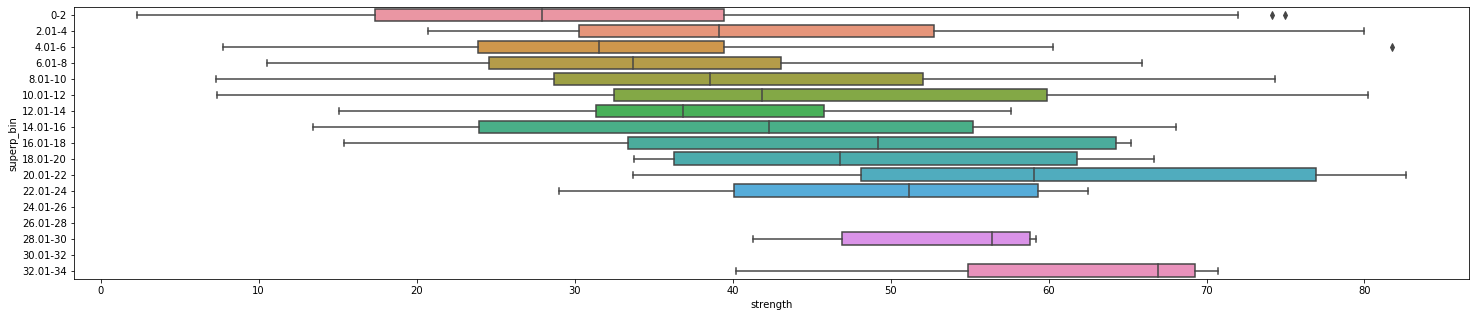

In [20]:
#bi-plot for superplastic_bin
for n in concrete_df_bin.columns[:-3]:
    fig, axs = plt.subplots(figsize= (25,5))
    cont_bi_box_plot_superp = sns.boxplot(x=concrete_df_bin[n],y=concrete_df_bin['superp_bin'])
    plt.show()
# SuperplasticBin vs water correlation is visible
# SuperplasticBin vs strength correlation is visible

# 3. Feature Engineering

In [21]:
concrete_df_interaction = concrete_df.copy()
col = 1
for i in concrete_df.columns[:-1]:
    for j in concrete_df.columns[:-1]:
        if i == j:
            print('Skip')
        else:
            concrete_df_interaction[str(i)+'/'+str(j)] = concrete_df_interaction[i]/concrete_df_interaction[j]
            col = col+1
#Get all interaction

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


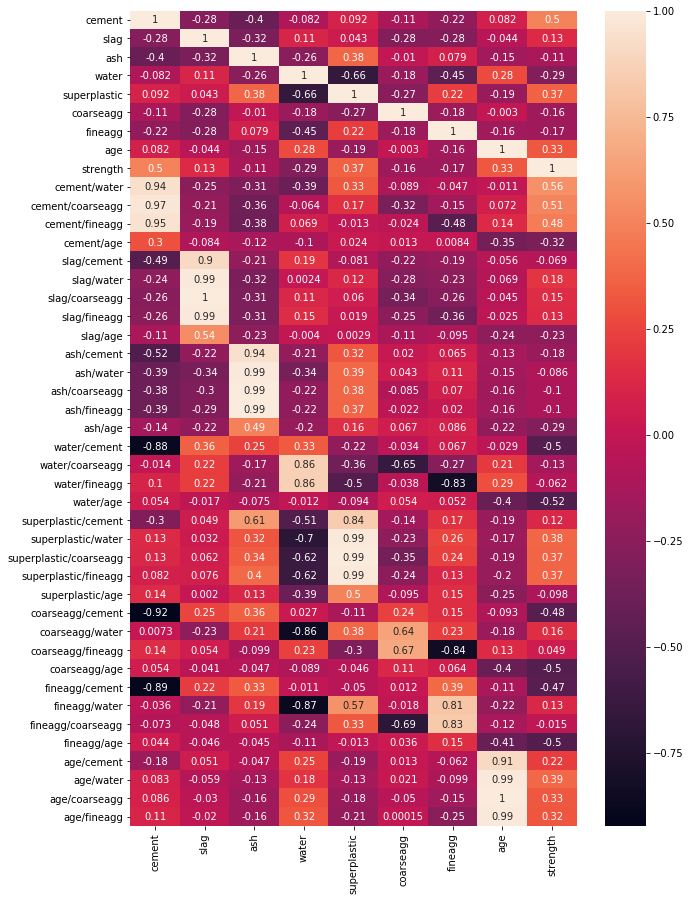

In [22]:
#Drop any column that contains 'inf' value
pd.set_option('use_inf_as_na', True)
concrete_df_interaction = concrete_df_interaction.drop(concrete_df_interaction.columns[concrete_df_interaction.apply(lambda col: col.isnull().sum() > 0)], axis=1)
corr_interaction = concrete_df_interaction.corr() 
# corr_interaction[:9].T

fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(corr_interaction[:9].T, annot=True, ax=ax)


#Some correlations can be seen with interactions but these interactions can bee seen with just feature variable correlations hence interactions will not be used in Machine learning.
#Anything above 0.8 or below -0.8 are correlated to its own parameter so it can be ignored.


In [23]:
#Create Training, Validation, and Test Set
concrete_df_rev = concrete_df.copy()
seed = 77
X_train, X_test, y_train, y_test = train_test_split(concrete_df_rev.drop('strength',axis=1)
                                                    , concrete_df_rev['strength'], test_size=0.2,random_state=seed)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=seed)

In [24]:
#Standardize all of features except output column
sc = StandardScaler()
X_train = sc.fit_transform(X_train) 
# X_val = sc.fit_transform(X_val) 
X_test = sc.transform(X_test)

In [25]:
# Linear Regression, Lasso Regression, and Ridge Regression
lr = LinearRegression() 
lasso = Lasso() 
ridge = Ridge() 
# Fitting models on Training data 
lr.fit(X_train, y_train) 
lasso.fit(X_train, y_train) 
ridge.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test) 
y_pred_lasso = lasso.predict(X_test) 
y_pred_ridge = ridge.predict(X_test) 

In [26]:
#Below shows RMSE and R-square of all three Linear Regression Model
print("Model\t\t\t RMSE \t\t R2") 
print("""LinearRegression \t {:.1f} \t\t{:.2f}""".format(np.sqrt(mean_squared_error(y_test, y_pred_lr)), r2_score(y_test, y_pred_lr))) 
print("""LassoRegression \t {:.1f} \t\t{:.2f}""".format(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), r2_score(y_test, y_pred_lasso))) 
print("""RidgeRegression \t {:.1f} \t\t{:.2f}""".format( np.sqrt(mean_squared_error(y_test, y_pred_ridge)), r2_score(y_test, y_pred_ridge)))

Model			 RMSE 		 R2
LinearRegression 	 10.7 		0.55
LassoRegression 	 11.3 		0.50
RidgeRegression 	 10.7 		0.55


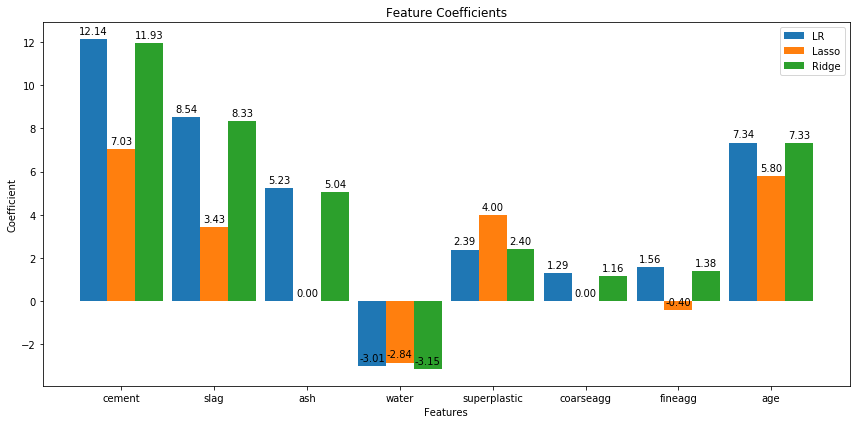

In [31]:
#Below shows Coefficient difference for all three linear regression model and depict how Coef behavior is changed.
width = 0.3 
labels = concrete_df[:-1] 
coeff_lr = lr.coef_ 
coeff_lasso = lasso.coef_ 
coeff_ridge = ridge.coef_ 
concrete_label = concrete_df.columns[:-1] 
x = np.arange(len(concrete_label)) 
fig, ax = plt.subplots(figsize=(12,6)) 
abc1 = ax.bar(x - 2*(width/2), coeff_lr, 0.3, label='LR') 
abc2 = ax.bar(x, coeff_lasso, 0.3, label='Lasso') 
abc3 = ax.bar(x + 2*(width/2), coeff_ridge, 0.3, label='Ridge') 
ax.set_ylabel('Coefficient') 
ax.set_xlabel('Features') 
ax.set_title('Feature Coefficients') 
ax.set_xticks(x) 
ax.set_xticklabels(labels) 
ax.legend() 
def autolabel(abc): 
    for lab in abc: 
        height = lab.get_height() 
        ax.annotate('{:.2f}'.format(height), xy=(lab.get_x() + lab.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom') 
autolabel(abc1) 
autolabel(abc2) 
autolabel(abc3) 
fig.tight_layout() 
plt.show()

In [32]:
#Test out Polynomial Regression
X = concrete_df.drop('strength', axis=1)
y = concrete_df[['strength']]

#Scale all of X features
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  

In [33]:
#poly = PolynomialFeatures(1-4)
for pol in range(1,5):
    poly = PolynomialFeatures(degree = pol, interaction_only=True)
    X_poly = poly.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=1)
        
    # Fitting models on Poly Training data 
    lr.fit(X_train, y_train) 
    lasso.fit(X_train, y_train) 
    ridge.fit(X_train, y_train)

    y_pred_lr = lr.predict(X_test) 
    y_pred_lasso = lasso.predict(X_test) 
    y_pred_ridge = ridge.predict(X_test) 
    
    #Below shows RMSE and R-square of all three Linear Regression Model
    print("Model Poly ",pol,"\t\t RMSE \t\t R2") 
    print("""LinearRegression \t {:.1f} \t\t{:.2f}""".format(np.sqrt(mean_squared_error(y_test, y_pred_lr)), r2_score(y_test, y_pred_lr))) 
    print("""LassoRegression \t {:.1f} \t\t{:.2f}""".format(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), r2_score(y_test, y_pred_lasso))) 
    print("""RidgeRegression \t {:.1f} \t\t{:.2f}\n""".format( np.sqrt(mean_squared_error(y_test, y_pred_ridge)), r2_score(y_test, y_pred_ridge)))
    
    
#2nd Degree performs better for all three regression and performance drops after 4th degree

Model Poly  1 		 RMSE 		 R2
LinearRegression 	 10.3 		0.63
LassoRegression 	 11.3 		0.56
RidgeRegression 	 10.3 		0.63

Model Poly  2 		 RMSE 		 R2
LinearRegression 	 8.6 		0.74
LassoRegression 	 10.8 		0.60
RidgeRegression 	 8.6 		0.74

Model Poly  3 		 RMSE 		 R2
LinearRegression 	 9.0 		0.72
LassoRegression 	 10.6 		0.61
RidgeRegression 	 9.0 		0.72

Model Poly  4 		 RMSE 		 R2
LinearRegression 	 9.7 		0.67
LassoRegression 	 10.5 		0.62
RidgeRegression 	 9.1 		0.72



# 4. Creating Model and Tuning it [1]

K_Fold_complete 10
Train Accuracy  86.67150230789424
K_Fold_complete 20
Train Accuracy  86.70907326313342
K_Fold_complete 30
Train Accuracy  86.49463794375774
K_Fold_complete 40
Train Accuracy  86.71649086731676
K_Fold_complete 50
Train Accuracy  86.80201213667657
K_Fold_complete 60
Train Accuracy  84.00745978142938
K_Fold_complete 70
Train Accuracy  84.42731260267612
Do Scatter




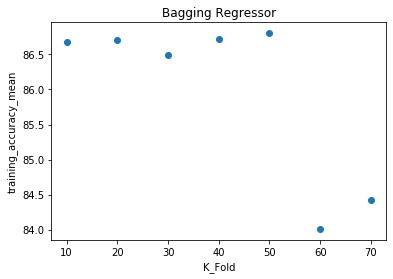

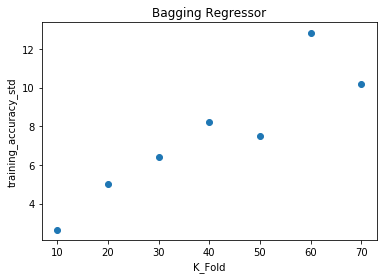

[0.81341833 0.89334994 0.81615657 0.76602454 0.66513121 0.84679708
 0.89569648 0.92870648 0.85866815 0.77973449]
test Accuracy: 82.637% (7.302%)


In [34]:
#Simple Leaner Model was created and tested using normal, and poly. 
#Below will continue to tune it by starting over with train_test model by using cross validation using different algorithms


concrete_df_rev2 = concrete_df.copy()
X_train, X_test, y_train, y_test = train_test_split(concrete_df_rev2.drop('strength',axis=1)
                                                    , concrete_df_rev2['strength'], test_size=0.35,random_state=77)

# 1) Bagging Regressor
br_train_mean = []
br_train_std = []
kfold = []

for k in range(10,80,10):
    pipe_br = Pipeline([('scl', StandardScaler()), ('br', BaggingRegressor(random_state=77))]) 
    train_results = cross_val_score(pipe_br, X_train, y_train, cv=k)
    br_train_mean.append(train_results.mean()*100)
    br_train_std.append(train_results.std()*100)
    kfold.append(k)
    print('K_Fold_complete',k)
    print('Train Accuracy ',train_results.mean()*100)



print('Do Scatter\n\n')
plt.scatter(kfold,br_train_mean) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("Bagging Regressor") 
plt.show()

plt.scatter(kfold,br_train_std) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("Bagging Regressor") 
plt.show()
#Accuracy starts to drop after 50 but accuracy is still similar with only 10 K-fold while std is low
#Going to use 10 K-fold for test mean.

#test out
test_results = cross_val_score(pipe_br, X_test, y_test, cv=10)
print(test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (test_results.mean()*100.0, test_results.std()*100.0))
#Test Accuracy came out to be 80% with training accuracy of 86% with overfit on training 


K_Fold_complete 10
XG Train Accuracy  89.83650793103101
K_Fold_complete 20
XG Train Accuracy  89.7796542751403
K_Fold_complete 30
XG Train Accuracy  90.29408132029765
K_Fold_complete 40
XG Train Accuracy  89.22117485762466
K_Fold_complete 50
XG Train Accuracy  89.83410836687213
K_Fold_complete 60
XG Train Accuracy  87.87235034148064
K_Fold_complete 70
XG Train Accuracy  88.8395424472697
Do Scatter




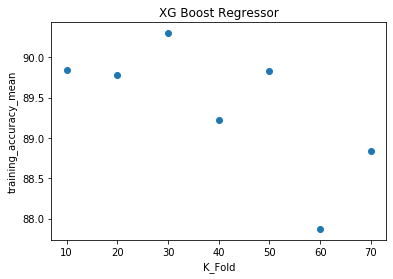

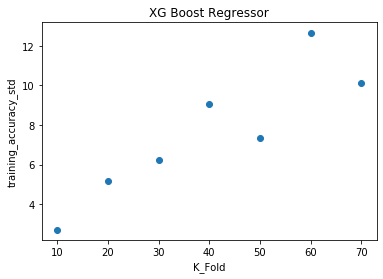

[0.90242152 0.89705397 0.8791873  0.86162053 0.74268072 0.89678299
 0.90741639 0.94004969 0.90490768 0.84673307]
test Accuracy: 87.789% (5.129%)


In [35]:
# 2) XG Boost
xg_train_mean = []
xg_train_std = []
kfold = []

for k in range(10,80,10):
    pipe_xg = Pipeline([('scl', StandardScaler()), ('xg', xgb.XGBRegressor(random_state = 77))]) 
    xg_train_results = cross_val_score(pipe_xg, X_train, y_train, cv=k)
    xg_train_mean.append(xg_train_results.mean()*100)
    xg_train_std.append(xg_train_results.std()*100)
    kfold.append(k)
    print('K_Fold_complete',k)
    print('XG Train Accuracy ',xg_train_results.mean()*100)


print('Do Scatter\n\n')
plt.scatter(kfold,xg_train_mean) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("XG Boost Regressor") 
plt.show()

plt.scatter(kfold,xg_train_std) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("XG Boost Regressor") 
plt.show()
#Accuracy starts to drop after 30 but accuracy is still similar with only 10 K-fold while std is low
#Going to use 10 K-fold for test mean with lowest std

#test out
xg_test_results = cross_val_score(pipe_xg, X_test, y_test, cv=10)
print(xg_test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (xg_test_results.mean()*100.0, xg_test_results.std()*100.0))
#Test Accuracy came out to be 87.8% with training accuracy of 89.8%.  
#This is better than Bagging


In [ ]:
# 3) Random Forest
rf_train_mean = []
rf_train_std = []
kfold = []

for k in range(10,80,10):
    pipe_rf = Pipeline([('scl', StandardScaler()), ('rf', RandomForestRegressor(random_state = 77))]) 
    rf_train_results = cross_val_score(pipe_rf, X_train, y_train, cv=k)
    rf_train_mean.append(rf_train_results.mean()*100)
    rf_train_std.append(rf_train_results.std()*100)
    kfold.append(k)
    print('K_Fold_complete',k)
    print('RF Train Accuracy ',rf_train_results.mean()*100)

print('Do Scatter\n\n')
plt.scatter(kfold,rf_train_mean) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("RF Regressor") 
plt.show()

plt.scatter(kfold,rf_train_std) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("RF Regressor") 
plt.show()
#Accuracy starts to drop after 30 but accuracy is still similar with only 10 K-fold while std is low
#Going to use 30 K-fold for test mean with highest accuracy but with low enough std

#test out
rf_test_results = cross_val_score(pipe_rf, X_test, y_test, cv=30)
print(rf_test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (rf_test_results.mean()*100.0, rf_test_results.std()*100.0))
#Test Accuracy came out to be 83.0% with training accuracy of 88.3%.  
#This is not better than XG Boost but better than Bagging

K_Fold_complete 10
RF Train Accuracy  87.8776362088207
K_Fold_complete 20
RF Train Accuracy  87.91193486416947
K_Fold_complete 30
RF Train Accuracy  88.31680712656956


In [ ]:
# 4) Support Vector Regressor
svr_train_mean = []
svr_train_std = []
kfold = []

for k in range(10,80,10):
    pipe_svr = Pipeline([('scl', StandardScaler()), ('svr', SVR())]) 
    svr_train_results = cross_val_score(pipe_svr, X_train, y_train, cv=k)
    svr_train_mean.append(svr_train_results.mean()*100)
    svr_train_std.append(svr_train_results.std()*100)
    kfold.append(k)
    print('K_Fold_complete',k)
    print('SVR Train Accuracy ',svr_train_results.mean()*100)

print('Do Scatter\n\n')
plt.scatter(kfold,svr_train_mean) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("SV Regressor") 
plt.show()

plt.scatter(kfold,svr_train_std) 
plt.xlabel("K_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("SV Regressor") 
plt.show()
#Accuracy starts to drop after 30 sharply along with std. K=10 was best but overall scores are low.
#Going to use 10 K-fold for test mean with highest accuracy but with low enough std

#test out
svr_test_results = cross_val_score(pipe_svr, X_test, y_test, cv=10)
print(svr_test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (svr_test_results.mean()*100.0, svr_test_results.std()*100.0))
#Test Accuracy came out to be 44.0% with training accuracy of 58.3%.  
#This is not better than any method above

In [ ]:
dict_df = {'Bagging Regressor':[test_results.mean(),test_results.std()],'XG_Boost Regressor':[xg_test_results.mean(),xg_test_results.std()]
          ,'Random Forest Regressor':[rf_test_results.mean(),rf_test_results.std()],'Support Vector Regressor':[svr_test_results.mean(),svr_test_results.std()]}
cv_model_df = pd.DataFrame.from_dict(dict_df,orient='index',columns=['TEST_MEAN','TEST_STD'])
cv_model_df.head()
#Below shows Mean and STD for each Regressor Models using Cross Validation
#XG_Boosting is the best Regressor out of all four with lowest STD from results

# 4. Creating Model and Tuning it [2]

In [ ]:
#Make copy to use this dataframe to compare Grid Search or Ramdom Search
cv_model_df_copy = concrete_df.copy()
X_train, X_test, y_train, y_test = train_test_split(cv_model_df_copy.drop('strength',axis=1)
                                                    , cv_model_df_copy['strength'], test_size=0.35,random_state=77)

In [ ]:
#Will use on XG_Boost Regressor or Random Foresh Regressor as both were the best out of four models given above
#Will use Random Search CV as lecture mentions that usually it performs better than Grid Search CV in probability wise

In [ ]:
# 1) Random Forest Regressor Random Search CV (too slow..)
rfrs_train_mean = []
rfrs_train_std = []
rfrs_iter = []

for rfrs in range(5,30,5):
    param_rf = {
                    "rf__max_depth": sp_randint(1,300),      
                    "rf__max_features": sp_randint(3, 8),
                    "rf__min_samples_leaf": sp_randint(1, 3),
                    "rf__ccp_alpha":[0, 0.001, 0.01, 0.1]
                }
    randomCV_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, n_iter=rfrs)
    randomCV_rf.fit(X_train, y_train)
    rfrs_train_mean.append(randomCV_rf.cv_results_['mean_test_score'].mean()*100)
    rfrs_train_std.append(randomCV_rf.cv_results_['mean_test_score'].std()*100)
    rfrs_iter.append(rfrs)
    print(randomCV_rf.cv_results_['mean_test_score'].mean()*100)
    print('cv_complete',rfrs)
    print(randomCV_rf.best_params_)
print(pipe_rf.get_params().keys())

#Choose best CV based on best mean
best_mean_index = rfrs_train_mean.index(max(rfrs_train_mean))
best_cv_on_best_mean = rfrs_iter[best_mean_index]


print('Do Scatter\n\n')
plt.scatter(rfrs_iter,rfrs_train_mean) 
plt.xlabel("Rand_CV_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("RandCV Random Forest Mean") 
plt.show()

plt.scatter(rfrs_iter,rfrs_train_std) 
plt.xlabel("Rand_CV_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("RandCV Random Forest STD") 
plt.show()
# Accuracy and STD are similar across all folds. 

In [ ]:
#Test out Random Search Random Forest
rand_CV_RF_test_results = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, n_iter=best_cv_on_best_mean).fit(X_test, y_test)
# print(rand_CV_RF_test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (rand_CV_RF_test_results.cv_results_['mean_test_score'].mean()*100
                                          , rand_CV_RF_test_results.cv_results_['mean_test_score'].std()*100))
print('Best Param: ',rand_CV_RF_test_results.best_params_)
#Test Accuracy came out to be 4% lower than training. Random CV did give higher training accuracy than just Random Forest
#This needs better parameter tweaking but computation is too slow..

In [ ]:
# 2) Bagging Regressor Random Search CV to make bad performer better (Too slow...)
#For some reasons, hyperparameters below that are commented out are making training accuracy too low
brrs_train_mean = []
brrs_train_std = []
brrs_iter = []


for brrs in range(5,30,5):
    param_br = {
                    "br__n_estimators":sp_randint(10,200)
#                     "br__max_features": sp_randint(3, 8),
#                     "br__bootstrap_features":[True,False],
#                     "br__max_samples":sp_randint(10,500)
                }
    randomCV_br = RandomizedSearchCV(pipe_br, param_distributions=param_br, n_iter=brrs)
    randomCV_br.fit(X_train, y_train)
    brrs_train_mean.append(randomCV_br.cv_results_['mean_test_score'].mean()*100)
    brrs_train_std.append(randomCV_br.cv_results_['mean_test_score'].std()*100)
    brrs_iter.append(brrs)
    print(randomCV_br.cv_results_['mean_test_score'].mean()*100)
    print('cv_complete',brrs)
    print(randomCV_br.best_params_)
print(pipe_br.get_params().keys())


best_mean_index = brrs_train_mean.index(max(brrs_train_mean))
best_cv_on_best_mean = brrs_iter[best_mean_index]


print('Do Scatter\n\n')
plt.scatter(brrs_iter,brrs_train_mean) 
plt.xlabel("Rand_CV_Fold") 
plt.ylabel("training_accuracy_mean") 
plt.title("RandCV Bagging Mean") 
plt.show()

plt.scatter(brrs_iter,brrs_train_std) 
plt.xlabel("Rand_CV_Fold") 
plt.ylabel("training_accuracy_std") 
plt.title("RandCV Bagging STD") 
plt.show()
# Accuracy and STD was best with 5 CV


In [ ]:
#Test out Random Search Bagging Regressor
rand_CV_BR_test_results = RandomizedSearchCV(pipe_br, param_distributions=param_br, n_iter=best_cv_on_best_mean).fit(X_test, y_test)
# print(rand_CV_RF_test_results)
print("test Accuracy: %.3f%% (%.3f%%)" % (rand_CV_BR_test_results.cv_results_['mean_test_score'].mean()*100
                                          , rand_CV_BR_test_results.cv_results_['mean_test_score'].std()*100))
print('Best Param: ',rand_CV_BR_test_results.best_params_)
#Test Accuracy came out to be 4% lower than training. Random CV give similar training accuracy than just Bagging
#This needs better parameter tweaking but computation is too slow..

In [ ]:
dict_df_rs = {'Bagging Regressor Random Search CV':[rand_CV_BR_test_results.cv_results_['mean_test_score'].mean()
                                                 ,rand_CV_BR_test_results.cv_results_['mean_test_score'].std()]
          ,'Random Forest Regressor Random Search CV':[rand_CV_RF_test_results.cv_results_['mean_test_score'].mean()
                                      ,rand_CV_RF_test_results.cv_results_['mean_test_score'].std()]}
cv_model_df_rs = pd.DataFrame.from_dict(dict_df_rs,orient='index',columns=['TEST_MEAN','TEST_STD'])
cv_model_final = pd.concat([cv_model_df,cv_model_df_rs])
cv_model_final.head(10)

# As Result, Both Bagging and Random Forest methods are same for both just CV and Random CV